Déroulement du [tutoriel](https://keras.io/examples/vision/deeplabv3_plus/) Keras sur DeepLabv3+

**/!\ Attention, utilise Keras 3**

# Paramétrage

## Librairies

In [ ]:
# partie spécifique Google Colab
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
# partie spécifique Google Colab
'''
If you install TensorFlow, critically, you should reinstall Keras 3 afterwards.
This is a temporary step while TensorFlow is pinned to Keras 2, and will no longer be necessary after TensorFlow 2.16.
The cause is that tensorflow==2.15 will overwrite your Keras installation with keras==2.15.
'''
!pip install --upgrade keras keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [ ]:
# partie spécifique Google Colab
!pip install rasterio plotly scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.6 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import glob
import plotly.express as px
import plotly.graph_objs as go
import cv2
import pandas as pd
import geopandas as gpd
import tqdm
from datetime import date
from google.colab import drive
import random
import matplotlib.pyplot as plt
import shapely
import os
import math

import skimage as ski
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

import keras
from keras import layers, Model, ops
from keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, Conv2DTranspose, \
MaxPooling2D, AveragePooling2D, SpatialDropout2D, BatchNormalization, Activation, SeparableConv2D, \
UpSampling2D, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img, img_to_array, array_to_img

import keras_cv

## Configuration du GPU

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Données

In [ ]:
# partie spécifique Google Colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# partie spécifique Google Colab
!mkdir -p /content/data/decoupe_final
!cp /content/drive/MyDrive/data/DST/df_decoupe_final.csv /content/data/decoupe_final/df_decoupe_final.csv
!unzip /content/drive/MyDrive/data/DST/decoupe_final.zip -d /content/data/decoupe_final

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.cpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.dbf  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.jp2  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.prj  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shp  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shx  
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg.aux.xml  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_label.png  
  inflating: /content/data/decoupe

In [ ]:
data_path = '/content/data/decoupe_final'
images_path = '/content/data/decoupe_final/decoupe_final'
df_decoupe = pd.read_csv(data_path + '/df_decoupe_final.csv')
df_decoupe.head()

dalle_X  dalle_Y         X          Y  X_size  Y_size  \
0        0        0  825000.0  6509800.0    1000    1000   
1        0        1  825000.0  6509600.0    1000    1000   
2        0        2  825000.0  6509400.0    1000    1000   
3        0        3  825000.0  6509200.0    1000    1000   
4        0        4  825000.0  6509000.0    1000    1000   

                          fichier_raster  \
0   69-2020_0_825000.0_0_6509800.0_0.jp2   
1   69-2020_1_825000.0_0_6509600.0_0.jp2   
2   69-2020_2_825000.0_0_6509400.0_4.jp2   
3   69-2020_3_825000.0_0_6509200.0_4.jp2   
4  69-2020_4_825000.0_0_6509000.0_19.jp2   

                                  fichier_img  \
0   69-2020_0_825000.0_0_6509800.0_0_data.jpg   
1   69-2020_1_825000.0_0_6509600.0_0_data.jpg   
2   69-2020_2_825000.0_0_6509400.0_4_data.jpg   
3   69-2020_3_825000.0_0_6509200.0_4_data.jpg   
4  69-2020_4_825000.0_0_6509000.0_19_data.jpg   

                                  fichier_mask  \
0   69-2020_0_825000.0_0_6509800.0_0_label.png   
1   69-2020_1_825000.0_0_6509600.0_0_label.png   
2   69-2020_2_825000.0_0_6509400.0_4_label.png   
3   69-2020_3_825000.0_0_6509200.0_4_label.png   
4  69-2020_4_825000.0_0_6509000.0_19_label.png   

                          fichier_shapes  formes  multi  erreur  
0   69-2020_0_825000.0_0_6509800.0_0.shp       0      0       0  
1   69-2020_1_825000.0_0_6509600.0_0.shp       0      0       0  
2   69-2020_2_825000.0_0_6509400.0_4.shp       4      0       0  
3   69-2020_3_825000.0_0_6509200.0_4.shp       4      0       0  
4  69-2020_4_825000.0_0_6509000.0_19.shp      19      0       0

## Fonctions

In [ ]:
def read_image(image_path, mask = False, resnet50_preprocess = True):
  image = tf_io.read_file(image_path)
  if mask:
    image = tf_image.decode_png(image, channels = 1)
    if BINARY_MASK:
      image = tf.where(tf.math.greater(image, 0), 1, 0)
    image.set_shape([None, None, 1])
    image = tf_image.resize(images = image, size = RESOLUTION)
  else:
    image = tf_image.decode_png(image, channels = 3)
    image.set_shape([None, None, 3])
    image = tf_image.resize(images = image, size = RESOLUTION)
    if resnet50_preprocess:
      # on reproduit le résultat de la fonction tf.keras.applications.resnet50.preprocess_input
      image = image[..., ::-1] - tf.constant(PIXEL_MEAN)
  return image

def load_data(image_list, mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list, mask = True)
  return image, mask

def data_generator(image_list, mask_list):
  dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
  dataset = (
    dataset
    .map(load_data, num_parallel_calls = tf_data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
  )
  return dataset

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer = keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear")(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus():
    model_input = keras.Input(shape=(SIZE, SIZE, 3))
    # /!\ PARTIE A ENLEVER CAR FAIT PLANTER LA SAUVEGARDE DU MODELE
    # A METTRE DANS LE PREPROCESSING
    # preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    # resnet50 = keras.applications.ResNet50(
    #    weights="imagenet", include_top=False, input_tensor=preprocessed)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(SIZE // 4 // x.shape[1], SIZE // 4 // x.shape[2]),
        interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(SIZE // x.shape[1], SIZE // x.shape[2]),
        interpolation="bilinear")(x)
    model_output = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1), padding="same", activation = 'softmax')(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
def show_segmentation_results(model, i_image, df_decoupe, seuil = 0.85):
  '''
  fonction qui permet d'afficher côte à côte :
  - le masque prédit par le modèle
  - le masque de départ, avec le contour prédit par le modèle
  - l'image de départ, avec le contour prédit par le modèle
  '''
  val_image = read_image(images_path + '/' + df_decoupe['fichier_img'].values[i_image])
  mask = tf.squeeze(model.predict(np.expand_dims(val_image, 0), verbose = 0))
  # on récupère le numéro de la classe prédite, c'est-à-dire celle
  # dont le softmax est le plus élevé
  mask = tf.where(tf.math.greater(tf.reduce_sum(mask[:,:,1:], -1), seuil), 1, 0).numpy()
  # la classe du masque est 1 : on cherche le contour "à l'intérieur"
  mask_contours = ski.measure.find_contours(image = mask == 1)
  print('{} forme(s) détectée(s) pour {} forme(s) présente(s)'.format(
      len(mask_contours),
      df_decoupe['formes'].values[i_image]))

  mask_target = read_image(images_path + '/' + df_decoupe['fichier_mask'].values[i_image], mask = True).numpy()

  f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharey=True, figsize=(15, 15))
  ax1.set_title('masque prédit')
  ax1.imshow(mask*100)
  ax2.set_title('masque du jeu de test')
  ax2.imshow(mask_target*100)

  ax3.set_title('contour prédit sur le masque du jeu de test')
  ax3.imshow(mask_target*100)
  ax4.set_title('contour prédit sur l\'image du jeu de test')
  ax4.imshow(array_to_img(val_image))

  ax5.set_title('bounding box du contour prédit sur le masque du jeu de test')
  ax5.imshow(mask_target*100)
  ax6.set_title('bounding box du contour prédit sur l\'image du jeu de test')
  ax6.imshow(array_to_img(val_image))

  ax7.set_title('polygone du contour prédit sur le masque du jeu de test')
  ax7.imshow(mask_target*100)
  ax8.set_title('polygone du contour prédit sur l\'image du jeu de test')
  ax8.imshow(array_to_img(val_image))

  for contour in mask_contours:
      ax3.plot(contour[:, 1], contour[:, 0], linewidth=1, color = 'red')
      ax4.plot(contour[:, 1], contour[:, 0], linewidth=1, color = '#f0fc03')
      bbox = cv2.boxPoints(cv2.minAreaRect(np.float32(contour)))
      bbox = np.append(bbox, [bbox[0]], axis = 0)
      ax5.plot(bbox[:, 1], bbox[:, 0], linewidth=1, color = 'red')
      ax6.plot(bbox[:, 1], bbox[:, 0], linewidth=1, color = '#f0fc03')
      polygon = ski.measure.approximate_polygon(contour, tolerance = 1)
      ax7.plot(polygon[:, 1], polygon[:, 0], linewidth=1, color = 'red')
      ax8.plot(polygon[:, 1], polygon[:, 0], linewidth=1, color = '#f0fc03')
  for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

In [ ]:
def calcul_performances(model, i_image, df_metrique, binary = True, seuil = None):

  val_image = read_image(images_path + '/' + df_metrique['fichier_img'].values[i_image])
  mask_target = read_image(images_path + '/' + df_metrique['fichier_mask'].values[i_image], mask = True)
  if binary:
    mask_target = tf.where(tf.math.greater(mask_target, 0), 1, 0)
  mask_target_reduced = tf.squeeze(mask_target)
  mask_raw = tf.squeeze(model.predict(tf.expand_dims(val_image, 0), verbose = 0))
  if seuil is None:
    mask = tf.argmax(mask_raw, axis = -1)
  else:
    mask = tf.where(tf.math.greater(mask_raw[:,:,1], seuil), 1, 0)

  if binary:
    nb_classes = 2
  else:
    nb_classes = 3
  iou = keras.metrics.MeanIoU(nb_classes, ignore_class = 0)
  iou.update_state(mask_target_reduced, mask)
  m_IoU = iou.result().numpy()
  # pour vérifier que le calcul Numpy est identique au calcul "à la main"
  # m_IoU_bis = calcul_IoU(mask_target.numpy(), mask.numpy())

  scce = keras.losses.SparseCategoricalCrossentropy()
  m_scce = scce(mask_target_reduced, mask_raw).numpy()

  sca = keras.metrics.SparseCategoricalAccuracy()
  sca.update_state(mask_target_reduced, mask_raw)
  m_sca = sca.result().numpy()

  return m_IoU, m_sca, m_scce

In [ ]:
def calcul_performances_tout(model, df_metrique, binary = True, seuil = None):

  metriques = []
  for i in tqdm.tqdm(range(df_metrique.shape[0])):
      metriques.append(list(calcul_performances(model, i, df_metrique, binary, seuil)))

  df_metrique['IoU'] = np.array(metriques)[:,0]
  df_metrique['sca'] = np.array(metriques)[:,1]
  df_metrique['scce'] = np.array(metriques)[:,2]

  return df_metrique

In [ ]:
def calcul_IoU(masque1, masque2, min_pixel = 1):
  if not masque1.shape==masque2.shape:
    print("masques de tailles incompatibles")
    return None
  else:
    M1 = masque1 > 0
    M2 = masque2 > 0
    return (min_pixel + np.sum(M1 & M2))/(min_pixel + np.sum(M1 | M2))

In [ ]:
def calcul_precision_recall(true_masque, pred_masque):
  if not true_masque.shape==pred_masque.shape:
    print("masques de tailles incompatibles")
    return None
  else:
    M_true_masque = true_masque > 0
    M_pred_masque = pred_masque > 0
    true_masque_0 = true_masque == 0
    pred_masque_0 = pred_masque == 0
    true_p = M_true_masque & M_pred_masque
    false_p = true_masque_0 & M_pred_masque
    false_n = M_true_masque & pred_masque_0
    # Recall = 1 when FN=0, since 100% of the TP were discovered
    if false_n.numpy().sum() == 0:
      recall = 1
    else:
      recall = true_p.numpy().sum()/(true_p.numpy().sum() + false_n.numpy().sum())
    # Precision = 1 when FP=0, since there were no spurious results
    if false_p.numpy().sum() == 0:
      precision = 1
    else:
      precision = true_p.numpy().sum()/(true_p.numpy().sum() + false_p.numpy().sum())
    return precision, recall

In [ ]:
def compare_ligne(df, chemin_images, index_l, resolution, affichage = True, binaire = False, img_norm = False, img_centrage = None, img_BGR = False, seuil = None):
  '''
  la fonction calcule et renvoie dans cet ordre :
  m_IoU, m_IoU_keras, m_sca, m_scce, precision, recall
  paramètres :
  - df : dataframe avec les informations de découpe
  - chemin_images : répertoire où sont stockées les images
  - index_l : numéro de ligne du dataframe
  - resolution : au format (hauteur, largeur)
  - affichage : si True, génération d'un graphique avec l'image, le masque, et le masque prédit
  - binaire : si le modèle est binaire, sinon 3 classes
  - img_norm : si l'image imput est normée (couleurs divisés par 255)
  - img_centrage : si définit, valeurs du pixel retranchée à tous les pixels de l'image founie au modèle
  - img_BGR : conversion RGB vers BGR
  - seuil : /!\ ne fonctionne que si l'on est en binaire, les classes "bâtiment" ne sont comptées que pour les valeurs supérieures au seuil
  '''
  file_name = chemin_images + df.loc[index_l,'fichier_img']
  mask_name = chemin_images + df.loc[index_l,'fichier_mask']

  # Image
  image = tf.io.read_file(file_name)
  image = tf.image.decode_png(image, channels = 3)
  img_reduite = tf.image.resize(images = image, size = resolution)
  if img_BGR:
    img_reduite = img_reduite[..., ::-1]
  if img_centrage is not None:
    img_reduite = img_reduite - tf.constant([img_centrage])
  if img_norm:
    img_reduite /= 255

  # Masque
  image_mask = tf.io.read_file(mask_name)
  image_mask = tf.image.decode_png(image_mask, channels = 1)
  if binaire :
    image_mask = tf.where(tf.math.greater(image_mask, 0), 1, 0)
  mask_reduit = tf.squeeze(tf.image.resize(images = image_mask, size = resolution))

  # Prévision
  prevision = tf.squeeze(model.predict(tf.expand_dims(img_reduite, 0), verbose=0))
  if seuil is None:
    prev_mask = tf.argmax(prevision, axis=-1)
    if binaire :
      prev_mask = tf.where(tf.math.greater(prev_mask, 0), 1, 0)
  else:
    # /!\ le seuil ne fonctionne qu'avec le mode binaire
    assert binaire
    # on somme toutes les probabilités de la 2e classe et des suivantes le cas échéant
    prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)

  # Métriques
  m_mask_reduit = tf.expand_dims(mask_reduit, -1)
  m_prev_mask = tf.expand_dims(prev_mask, -1)
  # Métrique IoU
  m_IoU = calcul_IoU(m_mask_reduit, m_prev_mask)
  # calcul avec Keras pour comparaison
  if binaire:
    nb_classes = 2
  else:
    nb_classes = 3
  iou = keras.metrics.MeanIoU(nb_classes, ignore_class = 0)
  iou.update_state(m_mask_reduit, m_prev_mask)
  m_IoU_keras = iou.result().numpy()
  # Métrique SparseCategoricalCrossEntropy
  scce = keras.losses.SparseCategoricalCrossentropy()
  m_scce = scce(m_mask_reduit, prevision).numpy()
  # Métrique SparseCategoricalAccuracy
  sca = keras.metrics.SparseCategoricalAccuracy()
  sca.update_state(m_mask_reduit, prevision)
  m_sca = sca.result().numpy()
  # Métriques precision & recall
  precision, recall = calcul_precision_recall(m_mask_reduit, m_prev_mask)

  # Affichages
  if affichage:
    print("Numéro image = ", index_l)
    print("Nombre de formes = ", df.loc[index_l,'formes'])
    print(file_name)
    print(mask_name)
    print(">> IoU = ", m_IoU)
    print(">> IoU (Keras) = ", m_IoU_keras)
    print(">> Accuracy = ", m_sca)
    print(">> CrossEntropy = ", m_scce)
    print(">> Precision = ", precision)
    print(">> Recall = ", recall)
    px.imshow(image).show()
    px.imshow(mask_reduit*255).show()
    px.imshow(prev_mask*255).show()

  # Fin
  return m_IoU, m_IoU_keras, m_sca, m_scce, precision, recall

In [ ]:
def predict_Deeplab(file_name, model, seuil):
  image = read_image(file_name)
  prevision = tf.squeeze(model.predict(tf.expand_dims(image, 0), verbose=0))
  prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)
  return [prev_mask]

In [ ]:
def predict_Deeplab_pretrained(file_name, model, seuil):
  image = read_image_pretrained(file_name)
  prevision = tf.squeeze(model.predict(tf.expand_dims(image, 0), verbose=0))
  prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)
  return [prev_mask]

In [ ]:
def calcul_ious_shapes(shapes_1_ext, shapes_2_ext):
  '''
  fonction qui calcule l'IoU des shapes_1_ext en cherchant à rapprocher les shapes_2_ext
  renvoie la liste des ious calculés
  '''
  ious = []
  rapprochements = []
  for i in range(len(shapes_1_ext)):
    shape_1 = shapely.Polygon(shapes_1_ext[i])
    unions = []
    unions.append(shape_1)
    intersections = []
    for j in range(len(shapes_2_ext)):
      shape_2 = shapely.Polygon(shapes_2_ext[j])
      if shape_2 is not None:
        if shape_1.intersects(shape_2):
          intersection = shape_1.intersection(shape_2)
          intersections.append(intersection)
          unions.append(shape_2)
    if len(intersections) > 0:
      intersection_area = shapely.area(gpd.GeoSeries(intersections, crs = 2154).unary_union)
    else:
      intersection_area = 0
    union_area = shapely.area(gpd.GeoSeries(unions, crs = 2154).unary_union)
    if union_area == 0:
      ious.append(0)
    else:
      ious.append(intersection_area/union_area)
    rapprochements.append(len(intersections))
  return ious, rapprochements

In [ ]:
def affiche_contours(
    model, predict_function, df, chemin_images, index_l, resolution_model, resolution_target = (1000, 1000),
    seuil = None, seuil_iou = 0, gdf_shapes_ref = None, affichage = True,
    seuil_area = 10,
    tolerance_polygone = 0.1):
  '''
  fonction qui calcule les IoU des formes prédites par rapport à des formes de référence
  utilise les mêmes arguements que compare_ligne, avec en plus :
  - predict_function : fonction qui prend en argument le triplet (file_name, model, seuil) et qui renvoie une liste de prévisions du modèle "model" sous forme
  de masque numpy.array avec les dimensions correspondant au paramètre "resolution_model", pour le seuil de détection "seuil"
  - seuil_iou : les formes avec un IoU inférieur sont affichées en rouge
  - gdf_shapes_ref : fichier de shapefiles à utiliser pour la comparaison des formes prédites > par défaut, on compare par rapport aux formes du df_decoupe
  renvoie :
  - geoSeries avec les formes prédites, crs 2154, avec uniquement les contours
  - geoSeries avec les formes de réference, crs 2154, avec uniquement les contours, et en fusionnant les formes adjacentes
  - shapes_pred_ious
  - shapes_ref_ious
  '''
  file_name = chemin_images + df.loc[index_l,'fichier_img']
  raster_name = chemin_images + df.loc[index_l, 'fichier_raster']
  shape_name = chemin_images + df.loc[index_l, 'fichier_shapes']

  # Prévision
  prev_masks = predict_function(file_name, model, seuil)
  # Contours prédiction
  mask_contours = []
  for prev_mask in prev_masks:
    prev_mask_resized = tf.squeeze(tf_image.resize(images = np.expand_dims(prev_mask, -1), size = resolution_target, method = 'nearest'))
    mask_padded = np.pad(prev_mask_resized, ((1, 1),(1, 1)), mode = 'constant', constant_values = 0)
    mask_contours += ski.measure.find_contours(image = mask_padded == 1)

  # Shapes prédiction
  with rasterio.open(raster_name) as raster:
    # création du convertisseur pour passer des coordonnées en pixels
    raster_transform = raster.transform
    raster_transformer = rasterio.transform.AffineTransformer(raster_transform)
    shapes_xy = []
    shapes_predict = []
    # parcours de tous les contours prédits
    for contour in mask_contours:
      # on crée le polygone
      polygon = approximate_polygon(contour, tolerance = tolerance_polygone)
      # on tranforme en coordonnées
      xy_polygon = raster_transformer.xy(polygon[:,0], polygon[:,1])
      shapes_xy.append(xy_polygon)
      # on crée le polygone
      shapes_predict.append(shapely.Polygon(np.array(xy_polygon).transpose()))
  # on filtre les surface trop petites
  shapes_predict = [shape for shape in shapes_predict if shapely.area(shape) > seuil_area]
  # Ajout des trous dans les shapes prédiction
  shapes_predict_holes = []
  shapes_holes = []
  for shape_a in shapes_predict:
    if shape_a not in shapes_holes:
      shape_a_holes = []
      for shape_b in shapes_predict:
        if shape_a.contains_properly(shape_b):
          shape_a_holes.append(shape_b.exterior)
          shapes_holes.append(shape_b)
      if len(shape_a_holes) > 0:
        shapes_predict_holes.append(shapely.Polygon(shape_a.exterior, holes = shape_a_holes))
      else:
        shapes_predict_holes.append(shape_a)
  gdf_shapes_predict = gpd.GeoDataFrame(geometry = gpd.GeoSeries(shapes_predict_holes, crs=2154), crs=2154)
  # gdf_shapes_predict = gdf_shapes_predict[gdf_shapes_predict['geometry'].is_valid].reset_index()

  # Shapes référence
  if gdf_shapes_ref is None:
    gdf_shapes_ref = gpd.read_file(shape_name)
  # gdf_shapes_ref = gdf_shapes_ref[gdf_shapes_ref['geometry'].is_valid].reset_index()
  # /!\ on court-circuite le traitement pour éviter de supprimer des formes de référence
  '''
  # Regroupement et fusion des formes adjacentes
  gdf_shapes_ref['group'] = ''
  for index in range(gdf_shapes_ref.shape[0]):
    group = gdf_shapes_ref[~gdf_shapes_ref.geometry.disjoint(gdf_shapes_ref.geometry[index])].index.to_list()
    if len(group) > 1:
      if gdf_shapes_ref.loc[index, 'group'] == '':
        gdf_shapes_ref.loc[group, 'group'] = 'group_' + str(index)
      else:
        gdf_shapes_ref.loc[group, 'group'] = gdf_shapes_ref.loc[index, 'group']
  gdf_shapes_ref_merged = gdf_shapes_ref.dissolve(by = 'group', as_index = False)
  gdf_shapes_ref_merged = gdf_shapes_ref_merged[gdf_shapes_ref_merged['geometry'].is_valid].reset_index()
  '''

  # Intersection et IoUs
  shapes_ref = gdf_shapes_ref['geometry'].exterior
  shapes_ref = [shape for shape in shapes_ref if shape is not None]
  shapes_predict = gdf_shapes_predict['geometry'].exterior
  shapes_predict = [shape for shape in shapes_predict if shape is not None]
  # iou des prédictions
  shapes_pred_ious, shapes_pred_rapprochements = calcul_ious_shapes(shapes_predict, shapes_ref)
  # iou des réferences
  shapes_ref_ious, shapes_ref_rapprochements = calcul_ious_shapes(shapes_ref, shapes_predict)

  fig = None
  if affichage:
    # lecture du raster
    raster_file = chemin_images + df.loc[index_l,'fichier_raster']
    with rasterio.open(raster_file) as raster:
        bounds = raster.bounds
        raster_data = np.transpose(raster.read(), [1,2,0])

    # génération du graphique
    X0 = df.loc[index_l, 'X']
    Y0 = df.loc[index_l, 'Y']
    dalle_X = df.loc[index_l, 'dalle_X']
    dalle_Y = df.loc[index_l, 'dalle_Y']
    nb_formes = df.loc[index_l, 'formes']
    fig = px.imshow(
        cv2.flip(raster_data, 0),
        x = np.linspace(bounds.left, bounds.right, raster.width),
        y = np.linspace(bounds.bottom, bounds.top, raster.height),
        title = 'Image {}, {} ({}, {})<br>{} bâtiments<br>fichier {}<br>{} zones détectées'.format(
            str(X0), str(Y0), str(dalle_X), str(dalle_Y), str(nb_formes), raster_file,
            np.sum((np.array(shapes_pred_ious) <= seuil_iou) & (np.array(shapes_pred_rapprochements) == 0))),
        origin = 'lower')
    # ajout des formes
    shape_traces_to_plot = []
    # formes de référence
    for shape, iou, rapprochement in zip(shapes_ref, shapes_ref_ious, shapes_ref_rapprochements):
      list_x, list_y = shape.xy
      shape_traces_to_plot.append(
          go.Scatter(
              x = np.array(list_x),
              y = np.array(list_y),
              line = dict(color='black', width=1),
              mode = 'lines',
              fill = 'toself',
              fillcolor = '#80b1d3',
              opacity = 0.4,
              text = 'iou référence: {}<br>{} prédictions rapprochées'.format(iou, rapprochement),
              hoverinfo = 'text',
              showlegend = False))
    # formes prédites
    for shape, iou, rapprochement in zip(shapes_predict, shapes_pred_ious, shapes_pred_rapprochements):
      if iou <= seuil_iou and rapprochement == 0:
        color_shape = 'red'
      else:
        color_shape = '#ffed6f'
      list_x, list_y = shape.xy
      shape_traces_to_plot.append(
          go.Scatter(
              x = np.array(list_x),
              y = np.array(list_y),
              line = dict(color='black', width=1),
              mode = 'lines',
              fill = 'toself',
              fillcolor = color_shape,
              opacity = 0.4,
              text = 'iou prédiction: {}<br>{} bâtiments rapprochés'.format(iou, rapprochement),
              hoverinfo = 'text',
              showlegend = False))
    fig.add_traces(shape_traces_to_plot)
    # mise en forme
    fig.update_layout(
        xaxis=dict(title='X en Lambert93'),
        yaxis=dict(title='Y en Lambert93'),
        plot_bgcolor='white',
        height = 900,
        width = 900)

  return shapes_predict, shapes_ref, shapes_pred_ious, shapes_ref_ious, shapes_pred_rapprochements, shapes_ref_rapprochements, fig


# Modèle

## Paramètres globaux

In [ ]:
SIZE = 512
RESOLUTION = (SIZE, SIZE)
NUM_CLASSES = 2
BINARY_MASK = True
BATCH_SIZE = 16
SEED = 77
PIXEL_MEAN = [103.939, 116.779, 123.68]

## Pre-processing

In [ ]:
df_train, df_test = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)

input_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_img'].values]
mask_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_mask'].values]
input_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_img'].values]
mask_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_mask'].values]

train_dataset = data_generator(input_img_paths_train, mask_img_paths_train)

# tentative de data augmentation
# seed_flip = 1339
# seed_translate = 47
# data_augmentation = keras.Sequential([
#    keras.layers.RandomFlip(seed = seed_flip),
#    keras.layers.RandomTranslation(0.1, 0.1, fill_mode='constant', seed = seed_translate, fill_value=0.0)])
# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), data_augmentation(y)))

val_dataset = data_generator(input_img_paths_test, mask_img_paths_test)

print('Train Dataset: ', train_dataset)
print('Validation Dataset: ', val_dataset)

Train Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>
Validation Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>


## Construction

In [ ]:
model = DeeplabV3Plus()
model.summary()

## Entraînement

In [ ]:
today_date = date.today().strftime('%Y%m%d')

iou = keras.metrics.MeanIoU(num_classes = NUM_CLASSES, sparse_y_pred = False)
sparse_categorical_accuracy = keras.metrics.SparseCategoricalAccuracy()
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [sparse_categorical_accuracy, iou]
)

callbacks = [
    ModelCheckpoint(
        filepath = '/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_' + today_date  + '.keras',
        save_best_only = True),
    ReduceLROnPlateau(
        monitor = 'loss',
        min_delta = 0.005,
        patience = 3,
        factor = 0.2,
        cooldown = 3,
        verbose = 1)]

history = model.fit(train_dataset,
                    callbacks = callbacks,
                    epochs = 50,
                    batch_size = BATCH_SIZE,
                    validation_data = val_dataset)

model.save('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_' + today_date + '.keras')
np.save('/content/drive/MyDrive/DataScientest/Keras/history_DeeplabV3Plus_model_' + today_date + '.npy', history.history)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 278s 606ms/step - loss: 0.1099 - mean_io_u_1: 0.4338 - sparse_categorical_accuracy: 0.9561 - val_loss: 0.2209 - val_mean_io_u_1: 0.4036 - val_sparse_categorical_accuracy: 0.9237 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 588ms/step - loss: 0.0911 - mean_io_u_1: 0.4614 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.5064 - val_mean_io_u_1: 0.3554 - val_sparse_categorical_accuracy: 0.9119 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 591ms/step - loss: 0.0857 - mean_io_u_1: 0.4684 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1000 - val_mean_io_u_1: 0.5332 - val_sparse_categorical_accuracy: 0.9593 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 588ms/step - loss: 0.0861 - mean_io_u_1: 0.4788 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.3495 - val_mean_io_u_1: 0.3094 - val_sparse_categorical_accuracy: 0.9093 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━

In [ ]:
history_data = np.load('/content/drive/MyDrive/DataScientest/Keras/history_DeeplabV3Plus_model_20240107.npy', allow_pickle='TRUE').item()
df_history_data = pd.DataFrame({
    'epochs' : [*range(1, len(history_data['sparse_categorical_accuracy']) + 1)]*2,
    'sparse_categorical_accuracy' : history_data['sparse_categorical_accuracy'] + history_data['val_sparse_categorical_accuracy'],
    'phase' : ['train'] * len(history_data['sparse_categorical_accuracy']) + ['validation'] * len(history_data['val_sparse_categorical_accuracy'])})
fig_acc = px.line(
    df_history_data,
    x = 'epochs',
    y = 'sparse_categorical_accuracy',
    color = 'phase')
fig_acc.update_layout(
    title = 'sparse_categorical_accuracy test/val<br>modèle DeepLabV3+ (07.01)',
    xaxis_title = 'epoch',
    yaxis_title = 'sparse_categorical_accuracy',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_acc.write_html('/content/drive/MyDrive/DataScientest/Keras/acc_DeeplabV3Plus_model_20240107.html')
fig_acc.show()

In [ ]:
df_history_data = pd.DataFrame({
    'epochs' : [*range(1, len(history_data['mean_io_u_1']) + 1)]*2,
    'mean_io_u' : history_data['mean_io_u_1'] + history_data['val_mean_io_u_1'],
    'phase' : ['train'] * len(history_data['mean_io_u_1']) + ['validation'] * len(history_data['val_mean_io_u_1'])})
fig_acc = px.line(
    df_history_data,
    x = 'epochs',
    y = 'mean_io_u',
    color = 'phase')
fig_acc.update_layout(
    title = 'mean_iou test/val<br>modèle DeepLabV3+ (07.01)',
    xaxis_title = 'epoch',
    yaxis_title = 'mean_io_u',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_acc.write_html('/content/drive/MyDrive/DataScientest/Keras/iou_DeeplabV3Plus_model_20240107.html')
fig_acc.show()

## Résultats

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_20240107.keras')


In [ ]:
_, df_val = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)
df_val = df_val.reset_index()


24 forme(s) détectée(s) pour 41 forme(s) présente(s)


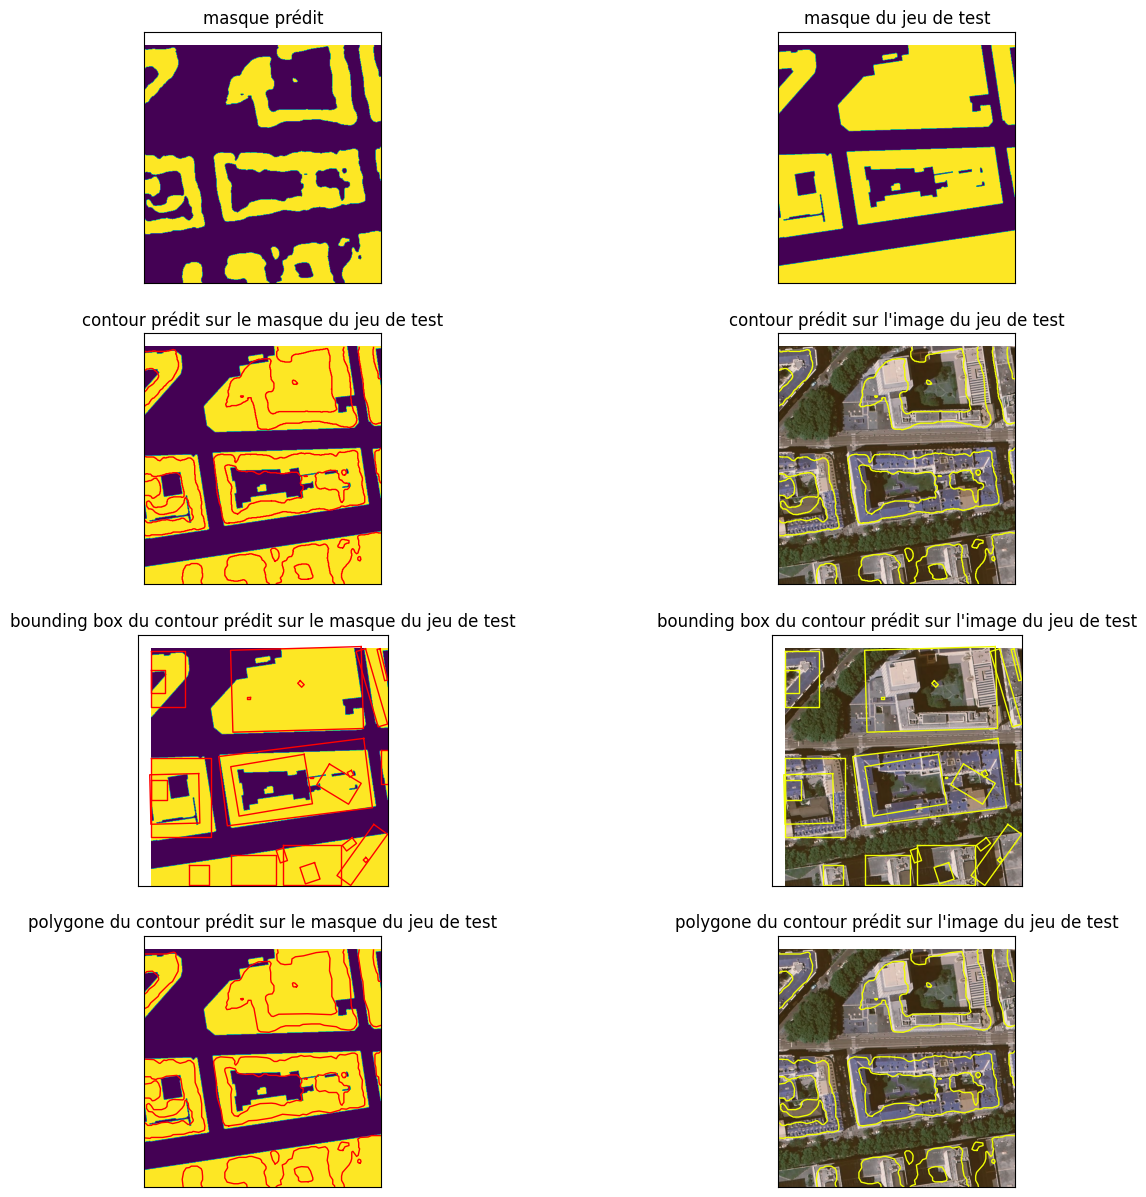

In [ ]:
i_image = 40
show_segmentation_results(model, i_image, df_val, seuil = 0.85)

# Modèle (3 classes)

## Paramètres globaux

In [ ]:
SIZE = 512
RESOLUTION = (SIZE, SIZE)
NUM_CLASSES = 3
BINARY_MASK = False
BATCH_SIZE = 16
SEED = 77
PIXEL_MEAN = [103.939, 116.779, 123.68]

## Pre-processing

In [ ]:
df_train, df_test = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)

input_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_img'].values]
mask_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_mask'].values]
input_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_img'].values]
mask_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_mask'].values]

train_dataset = data_generator(input_img_paths_train, mask_img_paths_train)
val_dataset = data_generator(input_img_paths_test, mask_img_paths_test)

print('Train Dataset: ', train_dataset)
print('Validation Dataset: ', val_dataset)

Train Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>
Validation Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>


## Construction

In [ ]:
model = DeeplabV3Plus()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │          0 │ input_layer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │      9,472 │ conv1_pad[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │        256 │ conv1_conv[0][0]           │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │          0 │ conv1_bn[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │          0 │ conv1_relu[0][0]           │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │          0 │ pool1_pad[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │      4,160 │ pool1_pool[0][0]           │
│ (Conv2D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │        256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │          0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │     36,928 │ conv2_block1_1_relu[0][0]  │
│ (Conv2D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │        256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │          0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │     16,640 │ pool1_pool[0][0]           │
│ (Conv2D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │     16,640 │ conv2_block1_2_relu[0][0]  │
│ (Conv2D)                  │                        │            │                            │
├──────────────────────

 Total params: 11,852,867 (45.22 MB)

 Trainable params: 11,820,131 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

## Entraînement

In [ ]:
today_date = date.today().strftime('%Y%m%d')

iou = keras.metrics.MeanIoU(num_classes = NUM_CLASSES, sparse_y_pred = False)
sparse_categorical_accuracy = keras.metrics.SparseCategoricalAccuracy()
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [sparse_categorical_accuracy, iou]
)

callbacks = [
    ModelCheckpoint(
        filepath = '/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_3_model_' + today_date  + '.keras',
        save_best_only = True),
    ReduceLROnPlateau(
        monitor = 'loss',
        min_delta = 0.005,
        patience = 3,
        factor = 0.2,
        cooldown = 3,
        verbose = 1)]

history = model.fit(train_dataset,
                    callbacks = callbacks,
                    epochs = 50,
                    batch_size = BATCH_SIZE,
                    validation_data = val_dataset)

model.save('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_3_model_' + today_date + '.keras')
np.save('/content/drive/MyDrive/DataScientest/Keras/history_DeeplabV3Plus_3_model_' + today_date + '.npy', history.history)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - loss: 0.2523 - mean_io_u: 0.2415 - sparse_categorical_accuracy: 0.9068 - val_loss: 415.9329 - val_mean_io_u: 0.2174 - val_sparse_categorical_accuracy: 0.3627 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - loss: 0.1670 - mean_io_u: 0.3259 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1531 - val_mean_io_u: 0.4118 - val_sparse_categorical_accuracy: 0.9418 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 751s 2s/step - loss: 0.1444 - mean_io_u: 0.3650 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1441 - val_mean_io_u: 0.4427 - val_sparse_categorical_accuracy: 0.9459 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 750s 2s/step - loss: 0.1339 - mean_io_u: 0.3833 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.2655 - val_mean_io_u: 0.3189 - val_sparse_categorical_accuracy: 0.8943 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - los

In [ ]:
history_data = np.load('/content/drive/MyDrive/DataScientest/Keras/history_DeeplabV3Plus_3_model_20240112.npy', allow_pickle='TRUE').item()
df_history_data = pd.DataFrame({
    'epochs' : [*range(1, len(history_data['sparse_categorical_accuracy']) + 1)]*2,
    'sparse_categorical_accuracy' : history_data['sparse_categorical_accuracy'] + history_data['val_sparse_categorical_accuracy'],
    'phase' : ['train'] * len(history_data['sparse_categorical_accuracy']) + ['validation'] * len(history_data['val_sparse_categorical_accuracy'])})
fig_acc = px.line(
    df_history_data,
    x = 'epochs',
    y = 'sparse_categorical_accuracy',
    color = 'phase')
fig_acc.update_layout(
    title = 'sparse_categorical_accuracy test/val<br>modèle DeepLabV3+ (12.01)<br>3 classes',
    xaxis_title = 'epoch',
    yaxis_title = 'sparse_categorical_accuracy',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_acc.write_html('/content/drive/MyDrive/DataScientest/Keras/acc_DeeplabV3Plus_3_model_20240107.html')
fig_acc.show()

In [ ]:
df_history_data = pd.DataFrame({
    'epochs' : [*range(1, len(history_data['mean_io_u']) + 1)]*2,
    'mean_io_u' : history_data['mean_io_u'] + history_data['val_mean_io_u'],
    'phase' : ['train'] * len(history_data['mean_io_u']) + ['validation'] * len(history_data['val_mean_io_u'])})
fig_acc = px.line(
    df_history_data,
    x = 'epochs',
    y = 'mean_io_u',
    color = 'phase')
fig_acc.update_layout(
    title = 'mean_iou test/val<br>modèle DeepLabV3+ (12.01)<br>3 classes',
    xaxis_title = 'epoch',
    yaxis_title = 'mean_io_u',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_acc.write_html('/content/drive/MyDrive/DataScientest/Keras/iou_DeeplabV3Plus_3_model_20240107.html')
fig_acc.show()

## Résultats

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_3_model_20240112.keras')


In [ ]:
_, df_val = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)
df_val = df_val.reset_index()


22 forme(s) détectée(s) pour 41 forme(s) présente(s)


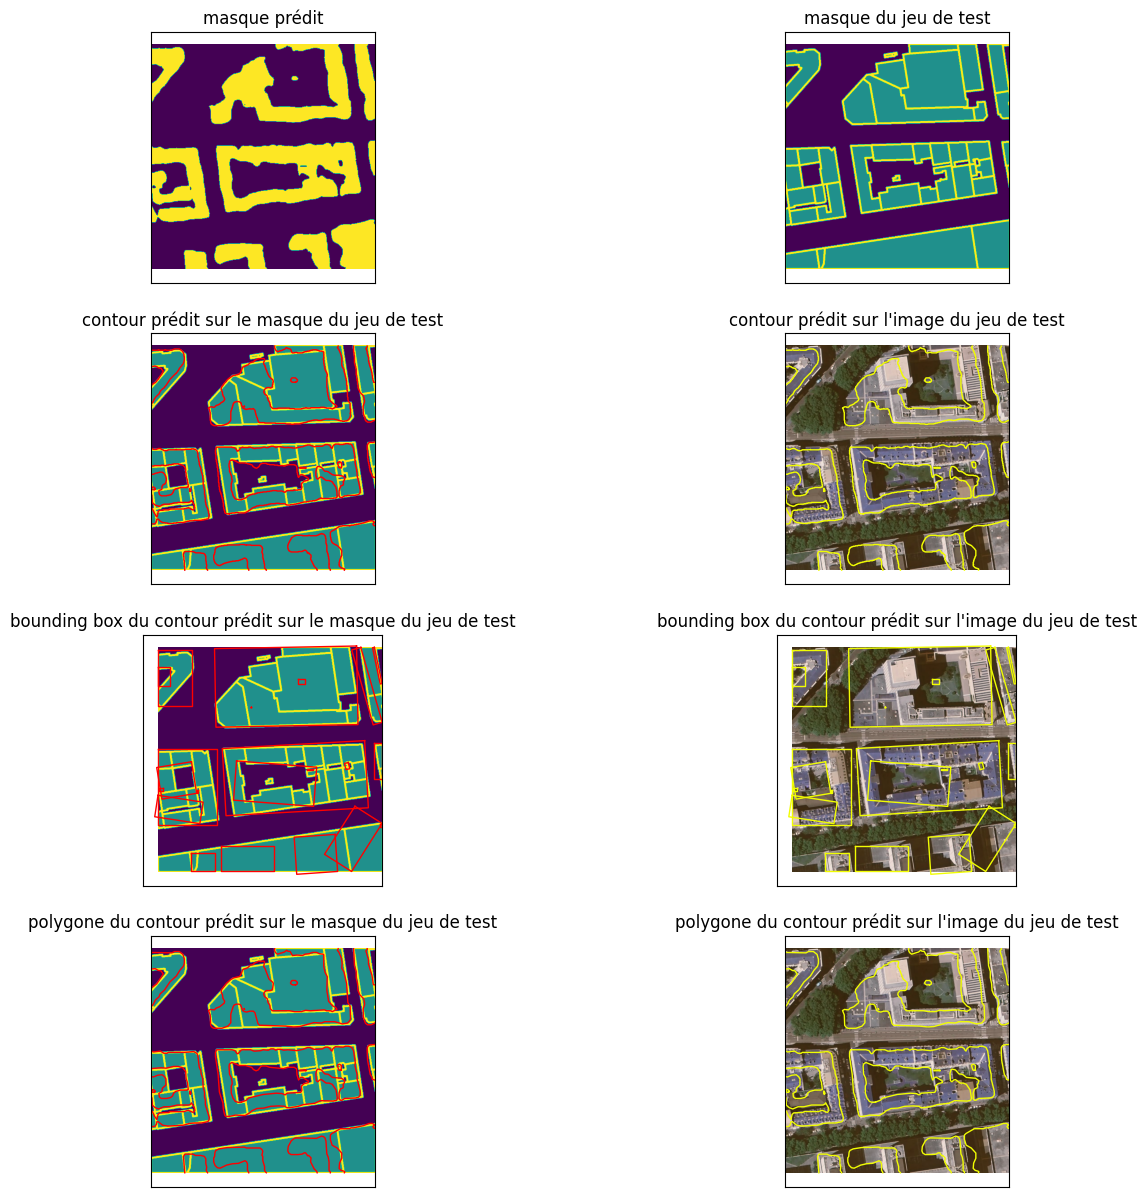

In [ ]:
i_image = 40
show_segmentation_results(model, i_image, df_val, seuil = 0.85)

# Modèle préentraîné

Modèle [préentraîné](https://www.kaggle.com/models/keras/deeplabv3plus) fourni par Tensorflow

## Paramètres globaux

In [ ]:
SIZE = 512
RESOLUTION = (SIZE, SIZE)
NUM_CLASSES = 3
BINARY_MASK = False
BATCH_SIZE = 4
SEED = 77

## Pré-processing

In [ ]:
def read_image_pretrained(image_path, mask = False):
  image = tf_io.read_file(image_path)
  if mask:
    image = tf_image.decode_png(image, channels = 1)
    if BINARY_MASK:
      image = tf.where(tf.math.greater(image, 0), 1, 0)
    image.set_shape([None, None, 1])
    image = tf_image.resize(images = image, size = RESOLUTION)
  else:
    image = tf_image.decode_png(image, channels = 3)
    image.set_shape([None, None, 3])
    image = tf_image.resize(images = image, size = RESOLUTION)
  return image

def load_data_pretrained(image_list, mask_list):
  image = read_image_pretrained(image_list)
  mask = read_image_pretrained(mask_list, mask = True)
  return image, mask

def data_generator_pretrained(image_list, mask_list):
  dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
  dataset = (
    dataset
    .map(load_data_pretrained, num_parallel_calls = tf_data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
  )
  return dataset

In [ ]:
df_train, df_test = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)

input_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_img'].values]
mask_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_train['fichier_mask'].values]
input_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_img'].values]
mask_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_mask'].values]

train_dataset = data_generator_pretrained(input_img_paths_train, mask_img_paths_train)
val_dataset = data_generator_pretrained(input_img_paths_test, mask_img_paths_test)

print('Train Dataset: ', train_dataset)
print('Validation Dataset: ', val_dataset)

NameError: name 'df_decoupe' is not defined

## Construction

In [ ]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc",
    input_shape = [SIZE, SIZE, NUM_CLASSES],
    num_classes = NUM_CLASSES)

100%|██████████| 10.5k/10.5k [00:00<00:00, 13.3MB/s]
100%|██████████| 150M/150M [00:10<00:00, 15.5MB/s]


In [ ]:
model.summary()

Model: "deep_lab_v3_plus_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, None, None, 3)  │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ functional_44             │ [(None, None, None,    │ 23,556,608 │ input_layer_24[0][0]       │
│ (Functional)              │ 256), (None, None,     │            │                            │
│                           │ None, 2048)]           │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ spatial_pyramid_pooling   │ (None, None, None,     │ 15,538,176 │ functional_44[0][1]        │
│ (SpatialPyramidPooling)   │ 256)                   │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ encoder_output_upsampling │ (None, None, None,     │          0 │ spatial_pyramid_pooling[0… │
│ (UpSampling2D)            │ 256)                   │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ sequential_27             │ (None, None, None, 48) │     12,480 │ functional_44[0][0]        │
│ (Sequential)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ concatenate_3             │ (None, None, None,     │          0 │ encoder_output_upsampling… │
│ (Concatenate)             │ 304)                   │            │ sequential_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ sequential_149            │ (None, None, None, 21) │     84,224 │ concatenate_3[0][0]        │
│ (Sequential)              │                        │            │                            │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 39,191,488 (149.50 MB)

 Trainable params: 39,146,464 (149.33 MB)

 Non-trainable params: 45,024 (175.88 KB)

## Entraînement

In [ ]:
today_date = date.today().strftime('%Y%m%d')

iou = keras.metrics.MeanIoU(num_classes = NUM_CLASSES, sparse_y_pred = False)
sparse_categorical_accuracy = keras.metrics.SparseCategoricalAccuracy()
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [sparse_categorical_accuracy, iou]
)

callbacks = [
    ModelCheckpoint(
        filepath = '/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_model_' + today_date  + '.keras',
        save_best_only = True),
    ReduceLROnPlateau(
        monitor = 'loss',
        min_delta = 0.005,
        patience = 3,
        factor = 0.2,
        cooldown = 3,
        verbose = 1)]

history = model.fit(train_dataset,
                    callbacks = callbacks,
                    epochs = 20,
                    batch_size = BATCH_SIZE,
                    validation_data = val_dataset)

model.save('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_model_' + today_date + '.keras')
np.save('/content/drive/MyDrive/DataScientest/Keras/history_DeeplabV3Plus_pretrained_model_' + today_date + '.npy', history.history)


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1464s 951ms/step - loss: 0.2504 - mean_io_u_2: 0.4321 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.5716 - val_mean_io_u_2: 0.3071 - val_sparse_categorical_accuracy: 0.9057 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1425s 950ms/step - loss: 0.2115 - mean_io_u_2: 0.4847 - sparse_categorical_accuracy: 0.9238 - val_loss: 0.3082 - val_mean_io_u_2: 0.3986 - val_sparse_categorical_accuracy: 0.8959 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1425s 950ms/step - loss: 0.1910 - mean_io_u_2: 0.5186 - sparse_categorical_accuracy: 0.9300 - val_loss: 0.2141 - val_mean_io_u_2: 0.4156 - val_sparse_categorical_accuracy: 0.9215 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1412s 941ms/step - loss: 0.1747 - mean_io_u_2: 0.5480 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.3146 - val_mean_io_u_2: 0.3354 - val_sparse_categorical_accuracy: 0.9100 - learning_rate: 0.0010
Epoch 5/20
1500/1500

# Statistiques

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_model_20240114.keras')

In [ ]:
_, df_metrique = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)
df_metrique = df_metrique.reset_index()


## Calcul avec les fonctions du modèle et les fonctions Keras directement

In [ ]:
df_metrique_Keras = calcul_performances_tout(model, df_metrique, binary = True)
df_metrique_Keras.to_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_metriques_Keras_20240107.csv')

print('')
print("Moyenne IoU = ", df_metrique_Keras.IoU.mean())
print("Moyenne SCA = ", df_metrique_Keras.sca.mean())
print("Moyenne SCCE = ", df_metrique_Keras.scce.mean())

100%|██████████| 1500/1500 [05:22<00:00,  4.65it/s]



Moyenne IoU =  0.26380008
Moyenne SCA =  0.9698613
Moyenne SCCE =  0.095491454


## Calcul avec la fonction générique

Utilisable par tous les modèles (a priori !)

In [ ]:
compare_ligne(
    df_metrique, images_path + '/', 40, resolution = RESOLUTION,
    affichage = True, binaire = True,
    img_norm = False, img_centrage = PIXEL_MEAN, img_BGR = True)

Numéro image =  40
Nombre de formes =  41
/content/data/decoupe_final/decoupe_final/69-2020_0_844000.0_20_6519800.0_41_data.jpg
/content/data/decoupe_final/decoupe_final/69-2020_0_844000.0_20_6519800.0_41_label.png
>> IoU =  0.7108312835762448
>> IoU (Keras) =  0.39125162
>> Accuracy =  0.81528854
>> CrossEntropy =  0.5113094
>> Precision =  0.9473688502532068
>> Recall =  0.7400544021811835


(0.7108312835762448,
 0.39125162,
 0.81528854,
 0.5113094,
 0.9473688502532068,
 0.7400544021811835)

In [ ]:
metriques = []
for i in tqdm.tqdm(range(df_metrique.shape[0])):
    metriques.append(list(compare_ligne(
        df_metrique, images_path + '/', i, resolution = RESOLUTION,
        affichage = False, binaire = True,
        img_norm = False, img_centrage = None, img_BGR = False)))

df_metrique['IoU'] = np.array(metriques)[:,0]
df_metrique['IoU_Keras'] = np.array(metriques)[:,1]
df_metrique['sca'] = np.array(metriques)[:,2]
df_metrique['scce'] = np.array(metriques)[:,3]
df_metrique.to_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_metriques_20240114.csv')

100%|██████████| 1500/1500 [06:28<00:00,  3.86it/s]


## Graphiques

In [ ]:
df_metrique = pd.read_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_metriques_20240114.csv')
print('')
print("Moyenne IoU = ", df_metrique.IoU.mean())
print("Moyenne IoU Keras = ", df_metrique.IoU_Keras.mean())
print("Moyenne SCA = ", df_metrique.sca.mean())
print("Moyenne SCCE = ", df_metrique.scce.mean())



Moyenne IoU =  0.6175006507156062
Moyenne IoU Keras =  0.28408978384671113
Moyenne SCA =  0.9464189097086588
Moyenne SCCE =  0.14417225667589806


In [ ]:
fig = px.scatter(df_metrique, x='formes',y=['IoU', 'IoU_Keras','sca'], title="Analyse des métriques modèle DeepLabV3+ préentraîné (14.01)<br>3 classes")
fig.update_layout(
    xaxis=dict(title='Nbr formes',),
    yaxis=dict(title='Métrique',),
    legend=dict(title="Métrique")
)
fig.show()

In [ ]:
fig = px.histogram(df_metrique, x='IoU', nbins=40, title="Analyse IoU modèle DeepLabV3+ préentraîné (14.01)<br>3 classes")
fig.update_layout(
    xaxis=dict(title='IoU',),
    yaxis=dict(title='Count',))
fig.update_layout(bargap=0.1)
fig.show()

In [ ]:
fig = px.histogram(df_metrique, x='IoU_Keras', nbins=40, title="Analyse IoU Keras modèle DeepLabV3+ préentraîné (14.01)<br>3 classes")
fig.update_layout(
    xaxis=dict(title='IoU Keras',),
    yaxis=dict(title='Count',))
fig.update_layout(bargap=0.1)
fig.show()

### Sensibilité au seuil de détection

Calcul de l'évolution des métriques en faisant varier le seuil de détection

In [ ]:
seuils = np.arange(0, 1.05, 0.05)
metriques = []
metriques_list = ['IoU', 'IoU_Keras', 'sca', 'scce', 'precision', 'recall', 'formes']
for seuil in tqdm.tqdm(seuils):
  for i in range(df_metrique.shape[0]):
    metriques.append(list(compare_ligne(
        df_metrique, images_path + '/', i,
        resolution = RESOLUTION, affichage = False, binaire = True,
        img_norm = False, img_centrage = None, img_BGR = False,
        seuil = seuil)) + [df_metrique['formes'].values[i]])
df_metriques_seuils = pd.DataFrame({
    'seuil': np.repeat(seuils, df_metrique.shape[0]*len(metriques_list)),
    'valeur': np.array(metriques).flatten(),
    'metrique': metriques_list*df_metrique.shape[0]*len(seuils)
})
df_metriques_seuils.to_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_metriques_seuil_20240114.csv')


100%|██████████| 21/21 [2:12:40<00:00, 379.07s/it]


In [ ]:
df_metriques_seuils = pd.read_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_pretrained_metriques_seuil_20240114.csv')


In [ ]:
fig_seuils = px.line(
    df_metriques_seuils.groupby(['seuil', 'metrique']).agg({'valeur':'mean'}).reset_index().query("metrique in ['IoU', 'IoU_Keras']"),
    x = 'seuil',
    y = 'valeur',
    color = 'metrique')
fig_seuils.update_layout(
    title = 'IoU en fonction du seuil<br>modèle DeepLabV3+ préentraîné (14.01)<br>3 classes',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_seuils.show()

In [ ]:
fig_PR = px.line(
    df_metriques_seuils.groupby(['seuil', 'metrique']).agg({'valeur':'mean'}).reset_index().pivot(index = ['seuil'], columns = ['metrique'], values = 'valeur').reset_index(),
    x = 'recall',
    y = 'precision',
    hover_data=['seuil'])
fig_PR.update_layout(
    title = 'Courbe PR modèle DeepLabV3+ préentraîné (14.01)<br>3 classes',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_PR.show()

# Contours

In [ ]:
_, _, _, _, _, _, fig = affiche_contours(
    model, predict_Deeplab, df_decoupe, images_path + '/', 6337,
    RESOLUTION, resolution_target = (1000, 1000),
    seuil = 0.25, seuil_iou = 0.01, gdf_shapes_ref = None, affichage = True,
    seuil_area = 30)
fig.show()

## IoUs

Calcul des TP, FP, FN en faisant varier le seuil de confiance et l'IoU

**1ere méthode**:

+ TP : iou_pred >= seuil_iou
+ FP : iou_pred ~ 0
+ FN : iou_ref ~ 0

DeeplabV3Plus_3_metriques_seuil_iou_20240112_old.csv

**2e méthode**:

+ TP : iou_pred >= seuil_iou
+ FP : iou_pred < seuil_iou
+ FN : iou_ref < seuil_iou

DeeplabV3Plus_3_metriques_seuil_iou_20240112.csv

In [ ]:
iou_0 = 0.01
seuils = np.arange(0, 1.05, 0.05)
ious = [0.01, 0.1, 0.2, 0.5, 0.7, 0.85, 0.95]

i_images_list = []
seuils_list = []
seuil_iou_list = []
TP_list = []
FP_list = []
FN_list = []

with tqdm.tqdm(total = len(seuils)*len(ious)*df_metrique.shape[0]) as pbar:
  for i_image in range(df_metrique.shape[0]):
    for seuil_detection in seuils:
      _, _, pred_ious, ref_ious, _, _, _ = affiche_contours(
          model, predict_Deeplab, df_metrique, images_path + '/', i_image,
          RESOLUTION, resolution_target = (1000, 1000),
          seuil = seuil_detection, seuil_iou = iou_0, gdf_shapes_ref = None, affichage = False,
          seuil_area = 30)
      for seuil_iou in ious:
        TP_list.append(np.sum(np.array(pred_ious) >= seuil_iou))
        FP_list.append(np.sum(np.array(pred_ious) <= seuil_iou))
        FN_list.append(np.sum(np.array(ref_ious) <= seuil_iou))
        seuils_list.append(seuil_detection)
        seuil_iou_list.append(seuil_iou)
        i_images_list.append(i_image)
        pbar.update(1)

df_metriques_seuils_ious = pd.DataFrame({
    'seuil': seuils_list,
    'seuil_iou' : seuil_iou_list,
    'i_images': i_images_list,
    'TP' : TP_list,
    'FP' : FP_list,
    'FN' : FN_list
})
df_metriques_seuils_ious.to_csv('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_3_metriques_seuil_iou_20240112.csv')



 97%|█████████▋| 214432/220500 [4:37:11<20:29,  4.94it/s]

# Brouillons

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_20240107.keras')

In [ ]:
_, df_contours = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)
df_contours = df_contours.reset_index()

In [ ]:

df = df_metrique
chemin_images = images_path + '/'
index_l = 40
resolution = RESOLUTION
binaire = True
img_norm = False
img_centrage = PIXEL_MEAN
img_BGR = True

file_name = chemin_images + df.loc[index_l,'fichier_img']
mask_name = chemin_images + df.loc[index_l,'fichier_mask']

# Image
image = tf.io.read_file(file_name)
image = tf.image.decode_png(image, channels = 3)
img_reduite = tf.image.resize(images = image, size = resolution)
if img_BGR:
  img_reduite = img_reduite[..., ::-1]
if img_centrage is not None:
  img_reduite = img_reduite - tf.constant([img_centrage])
if img_norm:
  img_reduite /= 255

# Prévision
prevision = tf.squeeze(model.predict(tf.expand_dims(img_reduite, 0), verbose=0))
prevision = tf.image.resize(images = prevision, size = (1000, 1000))
prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)

# Contour
mask_padded = np.pad(prev_mask, ((1, 1),(1, 1)), mode = 'constant', constant_values = 0)
mask_contours = ski.measure.find_contours(image = mask_padded == 1)



In [ ]:
with rasterio.open(chemin_images + df_contours['fichier_raster'].values[index_l]) as raster:
  # création du convertisseur pour passer des coordonnées en pixels
  raster_transform = raster.transform
  raster_transformer = rasterio.transform.AffineTransformer(raster_transform)
  shapes_xy = []
  shapes_predict = []
  # parcours de tous les contours prédits
  for contour in mask_contours:
    # on crée le polygone
    polygon = approximate_polygon(contour, tolerance=0.5)
    # on tranforme en coordonnées
    xy_polygon = raster_transformer.xy(polygon[:,0], polygon[:,1])
    shapes_xy.append(xy_polygon)
    # on crée le polygone
    shapes_predict.append(shapely.Polygon(np.array(xy_polygon).transpose()))


<Axes: >

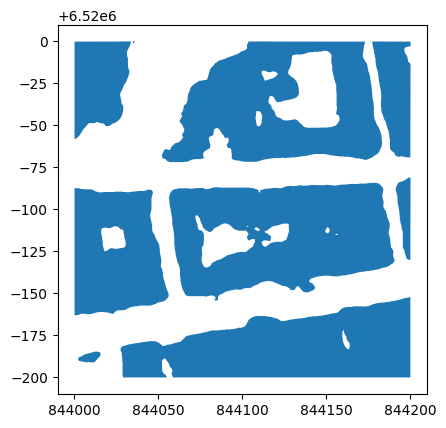

In [ ]:
shapes_predict_holes = []
shapes_holes = []
for shape_a in shapes_predict:
  if shape_a not in shapes_holes:
    shape_a_holes = []
    for shape_b in shapes_predict:
      if shape_a.contains_properly(shape_b):
        shape_a_holes.append(shape_b.exterior)
        shapes_holes.append(shape_b)
    if len(shape_a_holes) > 0:
      shapes_predict_holes.append(shapely.Polygon(shape_a.exterior, holes = shape_a_holes))
    else:
      shapes_predict_holes.append(shape_a)
s = gpd.GeoSeries(shapes_predict_holes, crs=2154)
gdf_shapes_predict_holes = gpd.GeoDataFrame(geometry = s, crs=2154)
gdf_shapes_predict_holes.plot()

<Axes: >

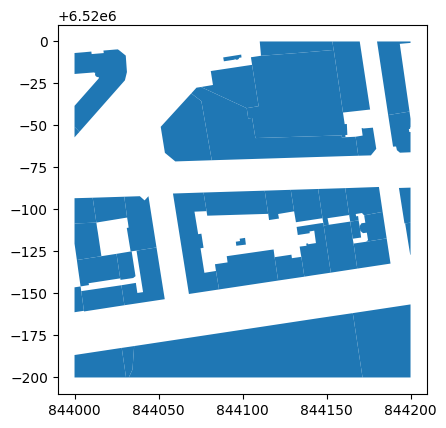

In [ ]:
gdf_shapes = gpd.read_file(chemin_images + df_contours['fichier_shapes'].values[index_l])
gdf_shapes.plot()

<Axes: >

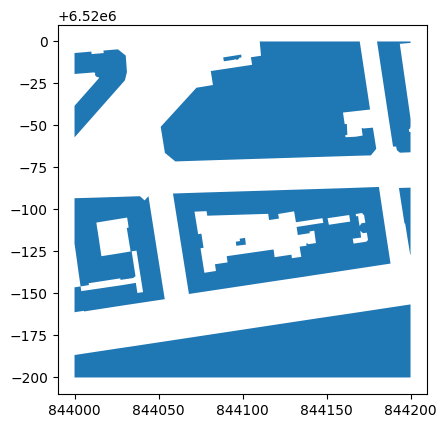

In [ ]:
gdf_shapes['group'] = ''
for index in range(gdf_shapes.shape[0]):
  group = gdf_shapes[~gdf_shapes.geometry.disjoint(gdf_shapes.geometry[index])].index.to_list()
  if len(group) > 1:
    if gdf_shapes.loc[index, 'group'] == '':
      gdf_shapes.loc[group, 'group'] = 'group_' + str(index)
    else:
      gdf_shapes.loc[group, 'group'] = gdf_shapes.loc[index, 'group']
gdf_shapes_merged = gdf_shapes.dissolve(by = 'group', as_index = False)
gdf_shapes_merged.plot()

<Axes: >

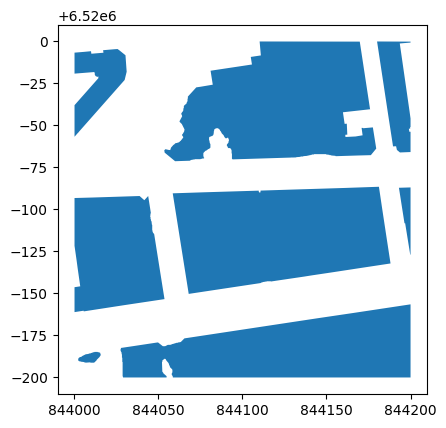

In [ ]:
gdf_shapes_merged_ext = gdf_shapes_merged['geometry'].exterior
gdf_shapes_predict_holes_ext = gdf_shapes_predict_holes['geometry'].exterior
intersections = []
ious = []
shapes_iou = []
for i in range(len(gdf_shapes_merged_ext)):
  shape_true = shapely.Polygon(gdf_shapes_merged_ext[i])
  union_area = shapely.area(shape_true)
  if union_area > 0:
    intersection_area = 0
    for j in range(len(gdf_shapes_predict_holes_ext)):
      shape_predict = gdf_shapes_predict_holes_ext[j]
      intersection = shapely.Polygon(shape_predict).intersection(shape_true)
      if intersection is not None:
        intersections.append(intersection)
        intersection_area += shapely.area(intersection)
        union_area += shapely.area(shape_predict)
    shapes_iou.append(shape_true)
    ious.append(intersection_area/union_area)

s = gpd.GeoSeries(intersections, crs = 2154)
gdf_intersections = gpd.GeoDataFrame(geometry = s, crs = 2154)
gdf_intersections.plot()

<Axes: >

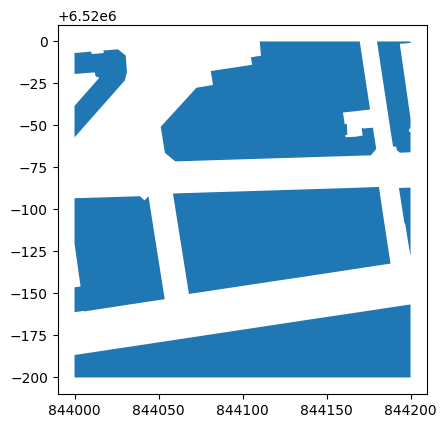

In [ ]:
s = gpd.GeoSeries(shapes_iou, crs = 2154)
gdf_ious = gpd.GeoDataFrame(geometry = s, crs = 2154)
gdf_ious.plot()

In [ ]:
len(gdf_shapes_merged_ext)

8